https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("../input/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes

0    284315
1       492
Name: Class, dtype: int64

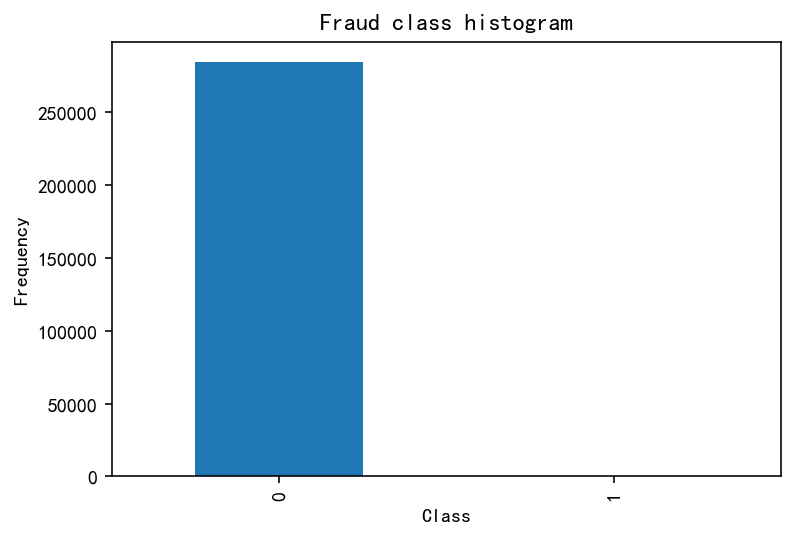

In [5]:
count_classes.plot(kind='bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

显然，数据是完全不平衡的！！

这是一个清晰的例子，使用典型的准确度评分来评估我们的分类算法。例如，如果我们只是使用一个多数类为所有记录赋值，那么我们仍然具有很高的准确性，但是我们会错误地对所有“1”进行分类！！

考虑到这种不平衡，有几种方法可以解决这一分类问题。

收集更多数据？策略不错，但在这种情况下不适用

更改性能指标：

使用confusio nmatrix计算精度，调用

F1分数（精确召回的加权平均值）

使用kappa-这是一种分类精度，通过数据中类的不平衡进行归一化。

ROC曲线-计算敏感性/特异性比率。

重新采样数据集

本质上，这是一种将数据处理成大约50-50比例的方法。

实现这一点的一种方法是通过过度抽样，即添加表示不足的类的副本（当您只有很少的数据时更好）

另一个是正在抽样，它从过度表示的类中删除实例（当他有大量数据时更好）

途径

我们不会首先执行功能工程。数据集已降级，以包含30个功能（28个非动态+时间+数量）。

然后，我们将比较使用重新采样和不使用它时会发生什么。我们将使用一个简单的逻辑回归分类器来测试这种方法。

我们将使用上面提到的一些性能指标来评估模型。

我们将通过调整逻辑回归分类器中的参数，重复最佳重采样/非重采样方法。

最后，我们将使用其他分类算法执行分类模型。

### Amount 数据归一化

In [8]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [10]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [12]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


In [13]:
y.head()

,Class
0,0
1,0
2,0
3,0
4,0


In [14]:
# Number of data points in the minority class
number_records_fraud = len(data[data.Class == 1])
number_records_fraud

492

In [18]:
fraud_indices = np.array(data[data.Class == 1].index)
normal_indices = data[data.Class == 0].index

## 正例和负例比例一样多，进行建模

In [24]:
# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(
    normal_indices, number_records_fraud, replace=False)

In [25]:
# Appending the 2 indices
# 下采样
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

In [26]:
# Under sample dataset
under_sample_data = data.iloc[under_sample_indices,:]
under_sample_data.shape

(984, 30)

In [28]:
X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class']

In [29]:
# Showing ratio
print("Percentage of normal transactions: ",
      len(under_sample_data[under_sample_data.Class == 0]) /
      len(under_sample_data))
print("Percentage of fraud transactions: ",
      len(under_sample_data[under_sample_data.Class == 1]) /
      len(under_sample_data))
print("Total number of transactions in resampled data: ",
      len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


In [30]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train) + len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(
    X_undersample, y_undersample, test_size=0.3, random_state=0)
print("")
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ",
      len(X_train_undersample) + len(X_test_undersample))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

In [38]:
# 网格搜索
def printing_Kfold_scores(x_train_data, y_train_data):
    fold = KFold(len(y_train_data), 5, shuffle=False)

    # Different C parameters
    c_param_range = [0.01, 0.1, 1, 10, 100]

    results_table = pd.DataFrame(
        index=range(len(c_param_range), 2),
        columns=['C_parameter', 'Mean recall score'])
    results_table['C_parameter'] = c_param_range

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        for iteration, indices in enumerate(fold, start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C=c_param, penalty='l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0], :],
                   y_train_data.iloc[indices[0], :].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(
                x_train_data.iloc[indices[1], :].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1], :].values,
                                      y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration, ': recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.ix[j, 'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

    best_c = results_table.loc[results_table['Mean recall score'].idxmax()][
        'C_parameter']

    # Finally, we can check which C parameter is the best amongst the chosen.
    print(
        '*********************************************************************************'
    )
    print('Best model to choose from cross validation is with C parameter = ',
          best_c)
    print(
        '*********************************************************************************'
    )

    return best_c

In [37]:
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample)

TypeError: shuffle must be True or False; got 5